## Wrangle and Analyse Data


This project primarily focuses on wrangling and visualising the tweet data found in the <a href='https://en.wikipedia.org/wiki/WeRateDogs'>WeRateDogs</a> twitter account. This data wasn't provided clean, it was spread across multiple files, different formats and structured in ways that required auditing and reshaping, so that it could be used in analysis. The notebook is separated into 3 stages, Gathering, Assessment and Cleaning. 


## Table of Contents 
1. <a href='#gathering'>Gathering</a>

2. <a href='#assessment'>Assessment</a>

3. <a href='#cleaning'>Cleaning</a>
    - <a href='#issue_1'>Quality Issues 1/2</a>
    - <a href='#issue_3'>Quality Issues 3/4</a>
    - <a href='#issue_5'>Quality Issue 5</a>
    - <a href='#issue_6'>Quality Issue 6</a>
    - <a href='#issue_7'>Quality Issue 7</a>
    - <a href='#issue_8'>Quality Issue 8</a>
    - <a href='#issue_9'>Tidiness Issue 1</a>
    - <a href='#issue_10'>Tidiness Issue 2</a>
    - <a href='#storage'>Storing Cleaned Data</a>

4. <a href='#visualisation'>Visualisation and Analysis</a>
5. <a href='#references'>References</a>

In [2]:
#import packages
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import tweepy as tw 
import requests 
import json
import re
import os 

% matplotlib inline

#API key variables stored in separate file 
%run twitter_keys

<a id='gathering'></a>
## Gathering

1. Supplied twitter_enhanced dataset must be loaded from file 
2. Image_prediction dataset must be scraped from Udacity website 
3. Archive tweet data must be queried through twitter API 
   - As we'll be using the tweet_id from the supplied twitter_enhanced dataset, the tweet_id column must first cleaned  before we gather more data to avoid any duplicates, reweets and responses to other tweets, this step will reduce the collection time associated with use of the API as well as avoid duplicates in the third dataset

In [3]:
#load supplied twitter data - csv format 
twitter_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
twitter_enhanced.head(4)
twitter_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
# check for duplicate tweet_ids
twitter_enhanced[twitter_enhanced.tweet_id.duplicated() == True].tweet_id.count()

0

In [6]:
#check for retweets
retweets = twitter_enhanced[twitter_enhanced.retweeted_status_id.isnull() == False]
retweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None


#### Issue 1/2
<a id='issue_1'></a>

In [7]:
#create copy of datatset
twitter_enhanced_clean = twitter_enhanced.copy()

In [8]:
#remove retweets
twitter_enhanced_clean = twitter_enhanced_clean[twitter_enhanced_clean.retweeted_status_id.isnull()]
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [9]:
#remove reply tweets
twitter_enhanced_clean = twitter_enhanced_clean[twitter_enhanced_clean.in_reply_to_status_id.isnull()]
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [10]:
#Instantiate tweepy object 
#key variables are declared in private python file, imported as twitter_keys
auth = tw.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tw.API(auth, parser=tw.parsers.JSONParser())

In [ ]:
#query API for tweet data 
#store only the data needed
tweet_data = []
exceptions = []
i = 0
for tweet_id in twitter_enhanced_clean['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended',
                               wait_on_rate_limit = True,
                               wait_on_rate_limit_notify = True)
        date = tweet['created_at']
        favourites = tweet['favorite_count']
        retweets = tweet['retweet_count']
        tweet_data.append({'tweet_id':int(tweet_id),
                           'creation_date':pd.to_datetime(date),
                           'favourites':int(favourites),
                           'retweets':int(retweets)})
    except Exception as e:
        print(str(e) + str(tweet_id))
        exceptions.append(tweet_id)

In [11]:
# Create dataframe and store result as csv file
tweets = pd.DataFrame(tweet_data)
tweets.to_json('tweet_json.txt', orient='columns')

NameError: name 'tweet_data' is not defined

In [13]:
#json file seems to be saving datetime as epoch time in milliseconds
tweets = pd.read_json('tweet_json.txt')
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 999
Data columns (total 4 columns):
creation_date    2090 non-null int64
favourites       2090 non-null int64
retweets         2090 non-null int64
tweet_id         2090 non-null int64
dtypes: int64(4)
memory usage: 81.6 KB


In [14]:
tweets.head()

,creation_date,favourites,retweets,tweet_id
0,1501604636000,36398,7741,892420643555336193
1,1501546647000,31348,5735,892177421306343426
10,1501029085000,28900,6729,890006608113172480
100,1496274205000,34798,7753,870063196459192321
1000,1459125823000,3280,829,714251586676113411


In [15]:
#json file seems to be saving datetime as epoch time in milliseconds
#index is also messed up 
tweets.creation_date = pd.to_datetime(tweets.creation_date, unit='ms')
tweets.reset_index(drop=True, inplace=True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 4 columns):
creation_date    2090 non-null datetime64[ns]
favourites       2090 non-null int64
retweets         2090 non-null int64
tweet_id         2090 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 65.4 KB


In [16]:
tweets.head()

,creation_date,favourites,retweets,tweet_id
0,2017-08-01 16:23:56,36398,7741,892420643555336193
1,2017-08-01 00:17:27,31348,5735,892177421306343426
2,2017-07-26 00:31:25,28900,6729,890006608113172480
3,2017-05-31 23:43:25,34798,7753,870063196459192321
4,2016-03-28 00:43:43,3280,829,714251586676113411


In [17]:
tweets[tweets.tweet_id.duplicated() == True].tweet_id.count()

0

In [18]:
#scrape image_predictions.tsv file from Udacity site 
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

#write to file 
with open(os.path.join('image_predictions.tsv'), mode = 'wb') as file:
    file.write(response.content)

In [19]:
#load image_predictions - tsv format 
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [20]:
image_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [21]:
twitter_enhanced_clean.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.097000e+03,0.0,0.0,0.0,0.0,2097.000000,2097.000000
mean,7.365594e+17,NaN,NaN,NaN,NaN,12.189318,10.448736
std,6.710178e+16,NaN,NaN,NaN,NaN,40.364996,6.645061
min,6.660209e+17,NaN,NaN,NaN,NaN,0.000000,2.000000
25%,6.768197e+17,NaN,NaN,NaN,NaN,10.000000,10.000000
50%,7.098528e+17,NaN,NaN,NaN,NaN,11.000000,10.000000
75%,7.877176e+17,NaN,NaN,NaN,NaN,12.000000,10.000000
max,8.924206e+17,NaN,NaN,NaN,NaN,1776.000000,170.000000


In [22]:
twitter_enhanced_clean.name.value_counts()

None        603
a            55
Charlie      11
Lucy         11
Cooper       10
Oliver       10
Penny         9
Tucker        9
Lola          8
the           8
Winston       8
Sadie         8
Toby          7
Daisy         7
Koda          6
Bella         6
an            6
Bo            6
Stanley       6
Bailey        6
Oscar         6
Jax           6
Leo           5
Bentley       5
Dave          5
Scout         5
Chester       5
Buddy         5
Milo          5
Louis         5
           ... 
Ashleigh      1
Rudy          1
Berb          1
Jessiga       1
Sky           1
Kody          1
Gin           1
Fletcher      1
Ruffles       1
Izzy          1
Reptar        1
Jiminus       1
Maya          1
Dudley        1
Kendall       1
Ken           1
Kawhi         1
Eugene        1
Banjo         1
Tonks         1
Fynn          1
Mary          1
Einstein      1
Chevy         1
Aja           1
Tupawc        1
Rupert        1
Mingus        1
Evy           1
Kevon         1
Name: name, Length: 955,

In [23]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 4 columns):
creation_date    2090 non-null datetime64[ns]
favourites       2090 non-null int64
retweets         2090 non-null int64
tweet_id         2090 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 65.4 KB


In [24]:
tweets.describe()

,favourites,retweets,tweet_id
count,2090.000000,2090.000000,2.090000e+03
mean,8393.688517,2536.132536,7.363484e+17
std,12194.900435,4441.547449,6.702051e+16
min,72.000000,11.000000,6.660209e+17
25%,1865.000000,560.500000,6.767853e+17
50%,3837.500000,1230.500000,7.095381e+17
75%,10473.000000,2882.000000,7.872326e+17
max,157142.000000,78286.000000,8.924206e+17


In [25]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [26]:
image_predictions.jpg_url.value_counts()

https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg                                            2
https://pbs.twimg.com/media/CcG07BYW0AErrC9.jpg                                            2
https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg                                            2
https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg                                            2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg    2
https://pbs.twimg.com/media/CvJCabcWgAIoUxW.jpg                                            2
https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg                                            2
https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg                                            2
https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg                       

<a id='assessment'></a>
# Assessment
### Quality 

**twitter_enhanced Dataframe**

  1. There are six columns missing values 
  2. Name column has None, a and the, appearing often as names. Further inspection excel confirms more cases
  3. if numbers have a decimal, the whole numbers appear to be cut off
  4. The 181 non-null retweet fields constitute non-original tweets in the dataset 
  5. reply columns respond to non-original tweets
  6. timestamp fields are type object not datetime 
  7. source text is wrapped in html tags
  
**twitter API dataframe**

  1. values are missing from several rows in the dataframe
  2. There are less rows overall compared to the twitter_enhanced dataframe, presumably because they were unable to be retrieved from twitter's archive
  3. tweet_id is an integer instead of a string
  
**image_prediction dataframe**
  1. There appears to be duplicate url links for a number of images
  
### Tidiness 
**twitter_enhanced Dataframe**
- retweet columns can be dropped as its non essential
- 181 rows of retweets are non-required
- reply columns are not required
- dog types are categorical and should be reduced to one column 

**twitter API dataframe**
- there are fewer rows in this table than the twitter enhanced table.
- only retweet count and favourite count are needed from this table, the rest can be dropped 
- dataframe needs to be merged with twitter_enhanced data

**image predictions dataframe**
- fewer rows than in twitter_enhanced dataframe
- image_prediction dataframe needs to be merged with twitter_enhanced data

<a id='cleaning'></a>
# Cleaning

### Quality issue 1/2 - removing rows that aren't original tweets

<a href='#issue_1'>Issue 1/2</a>

we cleaned the retweets and replies earlier from the twitter enhanced dataframe. Those columns can now be dropped

In [27]:
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

### Tidiness Issue 1 - dropping unrequired columns from twitter enhanced 
<a id='issue_9'></a>

In [28]:
#create copy of dataframe
#drop unrequired columns from twitter_enhanced
columns = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls']
twitter_enhanced_clean.reset_index(drop=True, inplace=True)
twitter_enhanced_clean.drop(columns, axis=1, inplace=True)
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 11 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(8)
memory usage: 180.3+ KB


In [29]:
#Recompute dog stage values
#mine tweet text for dog stages
stages = []
for text in twitter_enhanced_clean['text']:
    stage = re.findall('(floofer|pupper|doggo|puppo|Floofer|Pupper|Doggo|Puppo)', text)
    #reduces capitalised words to lowercase
    stage = [x.lower() for x in stage]
    #removes duplicates
    stage = list(set(stage))
    #if more than 1 stage, set stage to multiple
    if len(stage) > 1:
        stage = 'multiple'
    else:
        stage = ','.join(stage)
    stages.append(stage)
twitter_enhanced_clean['stage'] = stages
twitter_enhanced_clean['stage'].replace('', np.nan, inplace=True)

#test
twitter_enhanced_clean['stage'].value_counts()

pupper      243
doggo        78
puppo        28
multiple     12
floofer       9
Name: stage, dtype: int64

In [30]:
#drop stage columns 
columns = ['doggo','floofer','pupper','puppo']
twitter_enhanced_clean.drop(columns, axis=1, inplace=True)

In [31]:
#test
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 8 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
stage                 370 non-null object
dtypes: int64(3), object(5)
memory usage: 131.1+ KB


### Quality issue 3/4 - fixing values in Name column
<a id='issue_3'></a>

In [32]:
#find non-name words (any words beginning with a lowercase letter)
words = []
for name in twitter_enhanced_clean['name']:
    if name[0].islower() and name not in words:
        words.append(name)

In [33]:
print(words)

['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my', 'his', 'an', 'actually', 'just', 'getting', 'mad', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'light', 'space']


In [34]:
#replace occurences with Nan
twitter_enhanced_clean.name.replace(words, np.nan, inplace = True)

In [35]:
#replace None value with Nan
twitter_enhanced_clean.name.replace('None', np.nan, inplace = True)

In [36]:
twitter_enhanced_clean.name.value_counts()

Charlie     11
Lucy        11
Oliver      10
Cooper      10
Tucker       9
Penny        9
Winston      8
Sadie        8
Lola         8
Toby         7
Daisy        7
Stanley      6
Bo           6
Bailey       6
Bella        6
Jax          6
Oscar        6
Koda         6
Rusty        5
Bentley      5
Louis        5
Scout        5
Dave         5
Leo          5
Chester      5
Milo         5
Buddy        5
Boomer       4
Finn         4
Derek        4
            ..
Jareld       1
Jamesy       1
Kial         1
Rilo         1
Grizz        1
Dietrich     1
Geno         1
Chef         1
Meera        1
Akumi        1
Iroh         1
Jimbo        1
Bronte       1
Herschel     1
Shelby       1
Brooks       1
Lucky        1
Emmie        1
Rontu        1
Odin         1
Bubba        1
Dylan        1
Dawn         1
Mabel        1
Huxley       1
Stefan       1
Cupid        1
Charl        1
Darrel       1
Kevon        1
Name: name, Length: 929, dtype: int64

In [37]:
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 8 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1390 non-null object
stage                 370 non-null object
dtypes: int64(3), object(5)
memory usage: 131.1+ KB


### Quality issue 5 - collapsing image_prediction columns and removing non-dog types from DataFrame
<a id='issue_5'></a>

In [38]:
image_predictions_clean = image_predictions.copy()
p1 = image_predictions_clean[['tweet_id','p1', 'p1_conf','p1_dog']].copy()
p2 = image_predictions_clean[['tweet_id','p2', 'p2_conf','p2_dog']].copy()
p3 = image_predictions_clean[['tweet_id','p3', 'p3_conf','p3_dog']].copy()

p2.rename(columns={"p2": "p1", "p2_conf":"p1_conf", "p2_dog": "p1_dog"}, inplace=True)
p3.rename(columns={"p3": "p1", "p3_conf":"p1_conf", "p3_dog": "p1_dog"}, inplace=True)
p3.head()

,tweet_id,p1,p1_conf,p1_dog
0,666020888022790149,Shetland_sheepdog,0.061428,True
1,666029285002620928,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,bloodhound,0.116197,True
3,666044226329800704,miniature_pinscher,0.222752,True
4,666049248165822465,Doberman,0.154629,True


In [39]:
#aggregate dataframes
p1 = p1.append(p2, ignore_index=True)
p1 = p1.append(p3, ignore_index=True)
p1.rename(columns={'p1':'prediction','p1_conf':'confidence','p1_dog':'is_dog'}, inplace=True)
p1.head()

,tweet_id,prediction,confidence,is_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,redbone,0.506826,True
2,666033412701032449,German_shepherd,0.596461,True
3,666044226329800704,Rhodesian_ridgeback,0.408143,True
4,666049248165822465,miniature_pinscher,0.560311,True


In [40]:
#joining the original refactored columns with the image_prediction dataframe
image_predictions_clean = image_predictions_clean.merge(p1, on="tweet_id")

In [41]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 0 to 6224
Data columns (total 15 columns):
tweet_id      6225 non-null int64
jpg_url       6225 non-null object
img_num       6225 non-null int64
p1            6225 non-null object
p1_conf       6225 non-null float64
p1_dog        6225 non-null bool
p2            6225 non-null object
p2_conf       6225 non-null float64
p2_dog        6225 non-null bool
p3            6225 non-null object
p3_conf       6225 non-null float64
p3_dog        6225 non-null bool
prediction    6225 non-null object
confidence    6225 non-null float64
is_dog        6225 non-null bool
dtypes: bool(4), float64(4), int64(2), object(5)
memory usage: 607.9+ KB


In [42]:
#drop unrequired columns 
columns = ['p1','p1_conf','p1_dog','p2_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog', 'img_num']
image_predictions_clean.drop(columns, axis=1, inplace=True)
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 0 to 6224
Data columns (total 5 columns):
tweet_id      6225 non-null int64
jpg_url       6225 non-null object
prediction    6225 non-null object
confidence    6225 non-null float64
is_dog        6225 non-null bool
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 249.2+ KB


### Quality issue 6 - dropping non-dog rows from image_predictions
<a id='issue_6'></a>

In [43]:
#clean and test
image_predictions_clean.drop(image_predictions_clean[image_predictions_clean.is_dog == False].index, inplace=True)
image_predictions_clean.is_dog.value_counts()

True    4584
Name: is_dog, dtype: int64

### Tidiness issue 2 - Merging Dataframes (twitter_enhanced and tweets)
<a id='issue_10'></a>

In [44]:
#code and test
twitter = twitter_enhanced_clean.merge(tweets, on='tweet_id')
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 11 columns):
tweet_id              2090 non-null int64
timestamp             2090 non-null object
source                2090 non-null object
text                  2090 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  1383 non-null object
stage                 368 non-null object
creation_date         2090 non-null datetime64[ns]
favourites            2090 non-null int64
retweets              2090 non-null int64
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 195.9+ KB


In [ ]:
#The primary issue I have with merging the the image prediction and twitter_enhanced datatsets is that,
#it will result in duplicated row values



In [45]:
#drop duplicate date column and test
twitter.drop(columns=['creation_date'], axis=1, inplace=True)
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 10 columns):
tweet_id              2090 non-null int64
timestamp             2090 non-null object
source                2090 non-null object
text                  2090 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  1383 non-null object
stage                 368 non-null object
favourites            2090 non-null int64
retweets              2090 non-null int64
dtypes: int64(5), object(5)
memory usage: 179.6+ KB


### Quality issue 7 - changing columns to correct datatypes 
<a id='issue_7'></a>

In [46]:
#code
twitter['timestamp'] = pd.to_datetime(twitter['timestamp'])

In [47]:
twitter['stage'] = twitter['stage'].astype('category')

In [48]:
twitter['tweet_id'] = twitter['tweet_id'].astype('str')
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype('str')

In [49]:
#test
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 10 columns):
tweet_id              2090 non-null object
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  1383 non-null object
stage                 368 non-null category
favourites            2090 non-null int64
retweets              2090 non-null int64
dtypes: category(1), datetime64[ns](1), int64(4), object(4)
memory usage: 165.5+ KB


### Quality issue 8 - removing html from source column values
<a id='issue_8'></a>

In [50]:
#code
twitter.source = twitter.source.apply(lambda x: re.findall(r'>(.*)<', x)[0])

In [51]:
#test
twitter.source.value_counts()

Twitter for iPhone     1958
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

### Storing cleaned datasets
<a id='storage'></a>

In [52]:
twitter.to_csv('twitter_archive_master.csv')
image_predictions_clean.to_csv('image_predictions_master.csv')

## Visualisation and Analysis
<a id='visualisation'></a>

In [53]:
df = pd.read_csv('twitter_archive_master.csv')
df.timestamp = pd.to_datetime(df.timestamp)

In [54]:
df.set_index(pd.DatetimeIndex(df.timestamp), inplace=True)

In [55]:
dogs = df[df.stage.isnull() == False]

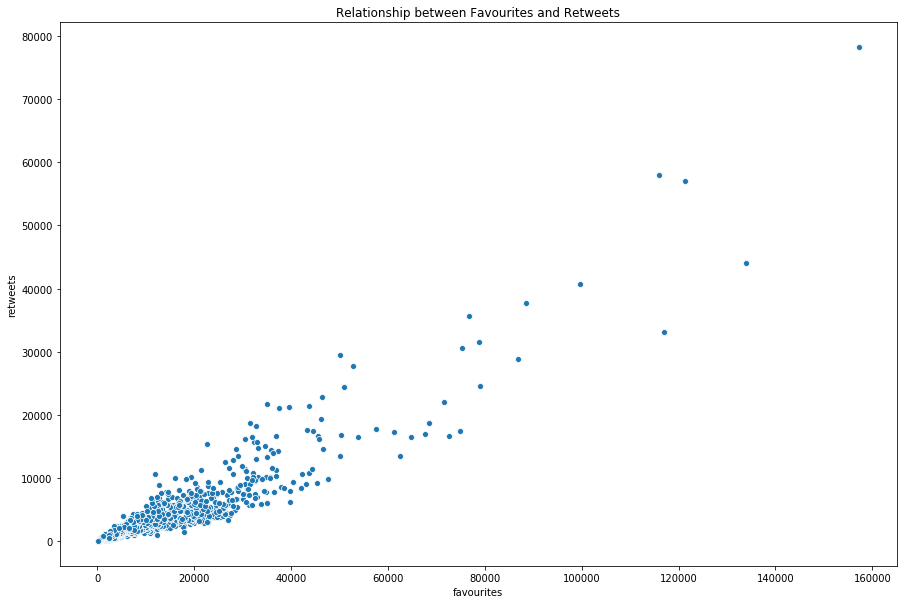

In [56]:
plt.subplots(figsize=(15,10))
sns.scatterplot(x=df.favourites, y=df.retweets, data=df);
plt.title('Relationship between Favourites and Retweets');

In [57]:
#find the correlation coeficient
np.corrcoef(df.retweets, df.favourites)[1][0]

0.9266718988547383

There appears to be a strong positive correlation between favourites and retweets which is unsurprising.

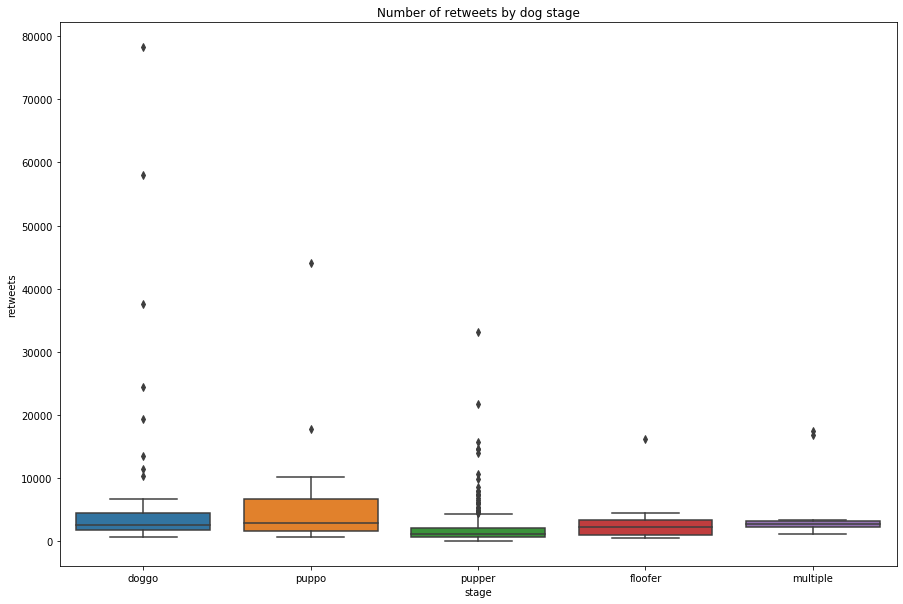

In [58]:
plt.subplots(figsize=(15,10))
sns.boxplot(x=dogs.stage, y=dogs.retweets, data=dogs);
plt.title('Number of retweets by dog stage');

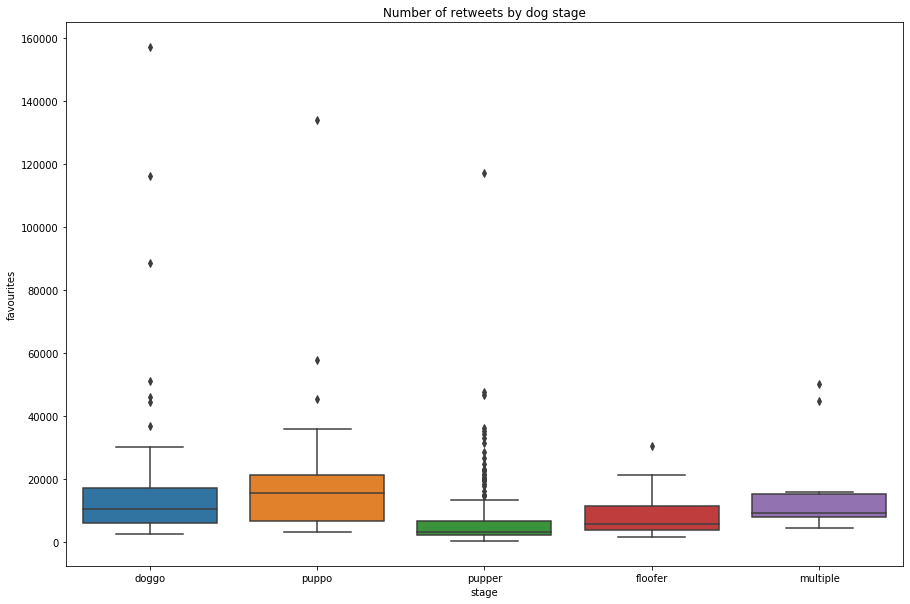

In [59]:
plt.subplots(figsize=(15,10))
sns.boxplot(x=dogs.stage, y=dogs.favourites, data=dogs);
plt.title('Number of retweets by dog stage');

In [60]:
pupper = df[df.stage == 'pupper']
puppo = df[df.stage == 'puppo']
doggo = df[df.stage == 'doggo']
floofer = df[df.stage == 'floofer']

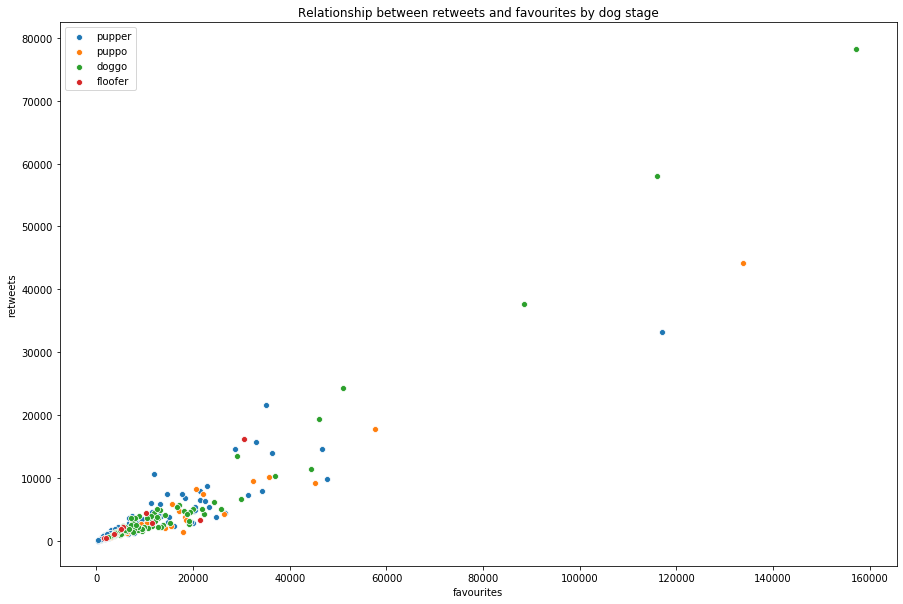

In [61]:
plt.subplots(figsize=(15,10))
ax = sns.scatterplot(x=pupper.favourites, y=pupper.retweets, data=pupper, label='pupper');
ax = sns.scatterplot(x=puppo.favourites, y=puppo.retweets, data=puppo, label='puppo');
ax = sns.scatterplot(x=doggo.favourites, y=doggo.retweets, data=doggo, label='doggo');
ax = sns.scatterplot(x=floofer.favourites, y=floofer.retweets, data=floofer, label='floofer');
ax.legend();
plt.title('Relationship between retweets and favourites by dog stage');

Its significantly harder to compare dog stages against each other due to the lack of data for floofers and puppos. Puppers seem to get slightly higher retweets compared to the proportion of favourites the other stages get. Puppers seem to have significantly more outliers. The higher number of direct mentions of Puppers in tweets seems to indicate that people find adolescent dogs the cutest. This could also just be a passing memeification trend of putting dog stages in tweets, with emphasis on Puppers particularly. Has the mention of dog stages increased on decreased over time?

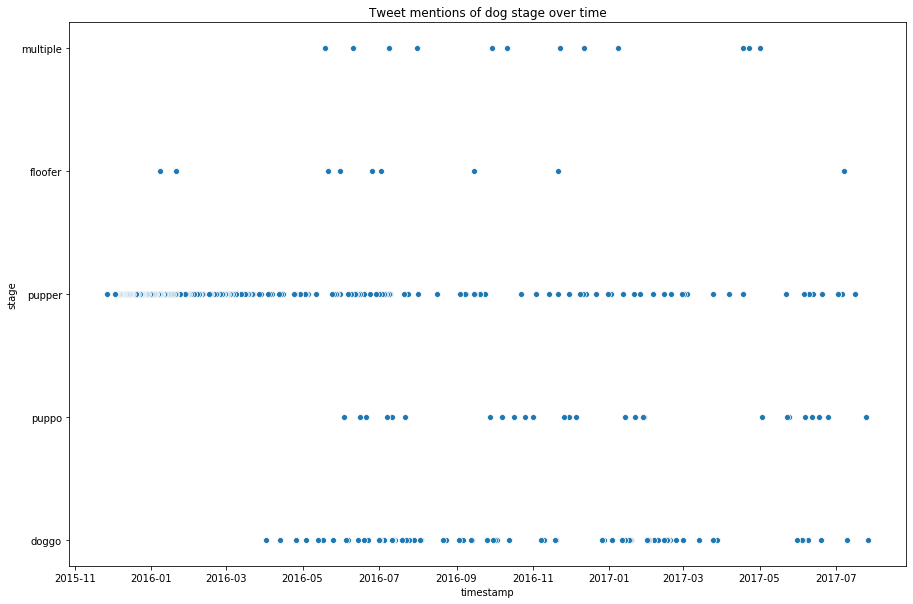

In [62]:
plt.subplots(figsize=(15,10))
sns.scatterplot(x=dogs.timestamp, y=dogs.stage, data=dogs);
plt.title('Tweet mentions of dog stage over time');

It appears the mentions of dog stages is starting to thin out over time. However from the data available, if you wanted to increase the number of favourites and or retweets by mentioning dog stage. A photo and mention of Puppo seems to the best way of ensuring even at the lowest values of retweets and favourites that it will be a popular tweet relative to other dog stages

<a id='references'></a>
# References 

https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
https://thispointer.com/pandas-apply-apply-a-function-to-each-row-column-in-dataframe/
https://docs.python.org/3/howto/regex.html
https://stackoverflow.com/questions/17255737/importing-variables-from-another-file
http://docs.tweepy.org/en/latest/api.html#status-methods
https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/
https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json
https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
https://stackoverflow.com/questions/6602111/how-to-search-for-a-capital-letter-within-a-string-and-return-the-list-of-words
https://sebastianraschka.com/Articles/2014_ipython_internal_links.html